<a href="https://colab.research.google.com/github/date333cs/courses/blob/master/infsoft200306.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Unreasonable Effectiveness of Automatic Differentiation**

## First Example

In [0]:
import numpy as np
import torch
 
x = torch.tensor(3.0, requires_grad=True)
y = x ** 3
y.backward()
print(x.grad)

tensor(27.)


In [0]:
x = torch.tensor(3.0, requires_grad=True)

## Second example

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# A ramdom vector approaches to [1,2,3,4,5].
x = torch.rand(5, requires_grad=True)
target = torch.tensor([1.0,2.0,3.0,4.0,5.0], requires_grad=False)

mu = 0.01 # the learning rate

d = []
for i in range(1000):
  distance = torch.norm(x - target)*torch.norm(x - target)
  d.append(distance.data)
  distance.backward(retain_graph=True)
  print(x.data)
  x.data.sub_(mu * x.grad.data)
  x.grad.data.zero_()



fig, ax = plt.subplots()
ax.plot(d)
ax.set_xlabel("iteration")
ax.set_ylabel("distance")
plt.show()
fig.savefig('ad001.pdf')

In [0]:
x = torch.rand(5, requires_grad=True)
x

tensor([0.5086, 0.2358, 0.6306, 0.1341, 0.0262], requires_grad=True)

## **System Identification**

## Problem 1

Consider this dynamical system:


$$  \left\{ \begin{array}{lll} \dot{x} & = & ~~ x + y - x(x^2+y^2) & & x(0)=x_0= 1\\ \dot{y} & = &  -x+y -y(x^2+y^2) & & y(0)=y_0=4 \end{array} \right. 
$$

Assume
* Equation are known.
* Initial conditions $(x_0, y_0)$ are unknown.
* Observe $(x(7), y(7))$

Find $(x_0, y_0)$

Write 
$ \tilde{x} (7)  = x(7; \tilde{x}_0, \tilde{y}_0 ), \tilde{y} (7)  = y(7; \tilde{x}_0, \tilde{y}_0 ) $
as functions of the initial conditions, and estimate
$ (x_0, y_0)$  by
$$ \hat{x}_0, \hat{y}_0 = {\rm arg} \min_{(\tilde{x}_0, \tilde{y}_0 )}   \parallel  (x(7),y(7)) -   (\tilde{x}(7),\tilde{y}(7))   \parallel^2 
$$

How? 
Give autograd the code that evaluates $ L =  \parallel  (x,y) -   (\tilde{x},\tilde{y})   \parallel^2  $ for a given $(x, y)$, and get
back the value of $L$ and its gradient.



[0.8305881  0.56135917]
0 : tensor([-2.,  0.], grad_fn=<CloneBackward>)
20 : tensor([-1.2530,  1.6377], grad_fn=<CloneBackward>)
40 : tensor([-0.2609,  2.0720], grad_fn=<CloneBackward>)
60 : tensor([0.2031, 2.0860], grad_fn=<CloneBackward>)
80 : tensor([0.3862, 2.0623], grad_fn=<CloneBackward>)
100 : tensor([0.4574, 2.0485], grad_fn=<CloneBackward>)
120 : tensor([0.4853, 2.0424], grad_fn=<CloneBackward>)
140 : tensor([0.4962, 2.0399], grad_fn=<CloneBackward>)
160 : tensor([0.5005, 2.0389], grad_fn=<CloneBackward>)
180 : tensor([0.5022, 2.0385], grad_fn=<CloneBackward>)
200 : tensor([0.5029, 2.0384], grad_fn=<CloneBackward>)
220 : tensor([0.5031, 2.0383], grad_fn=<CloneBackward>)
240 : tensor([0.5032, 2.0383], grad_fn=<CloneBackward>)
260 : tensor([0.5033, 2.0383], grad_fn=<CloneBackward>)
280 : tensor([0.5033, 2.0383], grad_fn=<CloneBackward>)
300 : tensor([0.5033, 2.0383], grad_fn=<CloneBackward>)
320 : tensor([0.5033, 2.0383], grad_fn=<CloneBackward>)
340 : tensor([0.5033, 2.0383], g

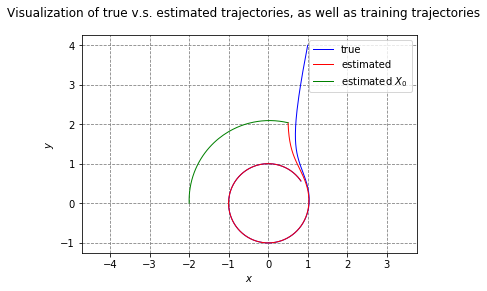

In [0]:
# -*- coding: utf-8 -*-
#
#    ad203.py written by A. Date 2019.12.1
#
import numpy as np
import torch
import matplotlib.pyplot as plt

T = 7 
dt = 0.01
N = int(T/dt)   # for deviding T, 0 =< t =< T into (N+1) descrete points
epochs = 500

# First of all, find the truth value of $ (x(7),y(7)) $
X0 = torch.tensor( [1.0, 4.0], requires_grad=True) # initial state
A = torch.tensor([[1.0, 1.0],[-1.0,1.0]])
x_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x_log[k] = X.data
  X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

print(x_log[N])

# Experiment 1: Estimate the initial state X0 from X7.
# X0 = torch.rand(2, requires_grad=True)
# X0 = torch.tensor( [0.5, 5.0],  requires_grad=True)
# X0 = torch.tensor( [2, 3.0],  requires_grad=True) # intial value. try various values.
X0 = torch.tensor( [-2.0, 0.0],  requires_grad=True) 

mu = 0.1
d = []

x0_log = np.zeros((epochs,2), dtype=float)

for i in range(epochs):
  X = torch.clone(X0)
  if i % 20 == 0:
    print(i,':',X)

  for k in range(N+1):
    X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

# discrete: [0.8305881  0.56135917] . 
  target = torch.tensor( [0.8305881, 0.56135917],  requires_grad=False)
  diff = torch.pow(X-target,2).sum()
  d.append(diff.data)
  diff.backward(retain_graph=True)

  with torch.no_grad(): 
    x0_log[i] = X0.data
#    X0.data.sub_(mu*X0.grad.data)
    X0.data.sub_(mu*X0.grad)
#    X0.grad.data.zero_()
    X0.grad.zero_()
# record estimaed trajectory
x2_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x2_log[k] = X.data
  X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

print(d)

fig = plt.figure()
fig.suptitle('Visualization of true v.s. estimated trajectories, as well as training trajectories') 
ax = fig.add_subplot(1,1,1) # make Axes.
ax.grid(True, color='gray', linestyle='dashed')
ax.plot(x_log[:,0], x_log[:,1], linewidth=1.0, color="b",linestyle="solid",label="true")
ax.plot(x2_log[:,0], x2_log[:,1], linewidth=1.0, color="r",linestyle="solid",label="estimated")
ax.plot(x0_log[:,0], x0_log[:,1], linewidth=1.0, color="g",linestyle="solid",label="estimated $X_0$")
ax.set_aspect('equal','datalim')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend()
plt.show()
fig.savefig('ad203.pdf') 

## Problem 2

Consider this dynamical system:

$$  \left\{ \begin{array}{lll} \dot{x} & = & ~~ ax + y - x(x^2+y^2) & & x(0)=x_0= 1\\ \dot{y} & = &  -x+y -y(x^2+y^2) & & y(0)=y_0=4 \end{array} \right. 
$$

Assume
* Equations and initial conditions known.
* $ a $  unknown .
* Observe $(x(7), y(7))$

Find $a$ (actural value is 1.0)


0 : tensor(5.)
20 : tensor(4.0925)
40 : tensor(3.5340)
60 : tensor(3.3517)
80 : tensor(3.3243)
100 : tensor(3.3214)
120 : tensor(3.3211)
140 : tensor(3.3210)
160 : tensor(3.3210)
180 : tensor(3.3210)
200 : tensor(3.3210)
220 : tensor(3.3210)
240 : tensor(3.3210)
260 : tensor(3.3210)
280 : tensor(3.3210)
300 : tensor(3.3210)
320 : tensor(3.3210)
340 : tensor(3.3210)
360 : tensor(3.3210)
380 : tensor(3.3210)
400 : tensor(3.3210)
420 : tensor(3.3210)
440 : tensor(3.3210)
460 : tensor(3.3210)
480 : tensor(3.3210)
[tensor(2.8788), tensor(2.8524), tensor(2.8267), tensor(2.8015), tensor(2.7769), tensor(2.7529), tensor(2.7294), tensor(2.7066), tensor(2.6843), tensor(2.6627), tensor(2.6416), tensor(2.6213), tensor(2.6015), tensor(2.5824), tensor(2.5639), tensor(2.5461), tensor(2.5289), tensor(2.5124), tensor(2.4966), tensor(2.4814), tensor(2.4669), tensor(2.4531), tensor(2.4399), tensor(2.4274), tensor(2.4156), tensor(2.4044), tensor(2.3939), tensor(2.3840), tensor(2.3747), tensor(2.3661), tens

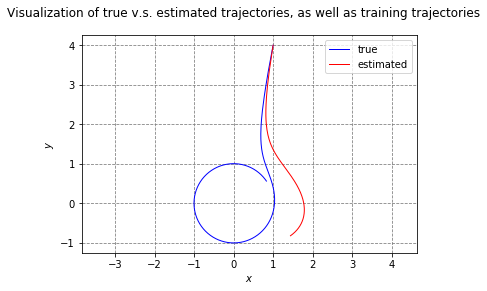

In [0]:
# -*- coding: utf-8 -*-
#
#    ad301.py written by A. Date 2019.12.1
#
import numpy as np
import torch
import matplotlib.pyplot as plt

T = 7 
dt = 0.01
N = int(T/dt)   # (N+1)点に分割
# epochs = 1100
epochs = 500

# Find the truth.

X0 = torch.tensor( [1.0, 4.0], requires_grad=True) # initial state
B = torch.tensor([[1.0, 1.0],[-1.0,1.0]])
x_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x_log[k] = X.data
  X = X + dt*( torch.matmul(B,X) - X.dot(X)*X )


# Experiment 2: Estimate the parameter value of 'a' given X0, X7.
# a = torch.tensor(0.5, requires_grad=True)  # works well
a = torch.tensor(5.0, requires_grad=True) # doesn't work well
# a = torch.rand(1, requires_grad=True)
X0 = torch.tensor( [1.0, 4.0])
A0 = torch.tensor([[0.0, 1.0],[-1.0,1.0]])

mu = 0.1
d = []

a_log = np.zeros(epochs,dtype=float)

for i in range(epochs):
  X = torch.clone(X0)
  A = torch.clone(A0)
  A[0][0] = torch.clone(a)
  
  if i % 20 == 0:
    print(i,':',a.data)

  for k in range(N+1):
    X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

# discrete: [0.8305881  0.56135917] . 
  target = torch.tensor( [0.8306, 0.5614],  requires_grad=False)
  diff = torch.pow(X-target,2).sum()
  d.append(diff.data)
  diff.backward(retain_graph=True)

  with torch.no_grad(): 
    a_log[i] = a.data
    a.data.sub_(mu*a.grad.data)
    a.grad.data.zero_()

# record estimaed trajectory
x2_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x2_log[k] = X.data
  X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

print(d)

fig = plt.figure()
fig.suptitle('Visualization of true v.s. estimated trajectories, as well as training trajectories') 
ax = fig.add_subplot(1,1,1)
ax.grid(True, color='gray', linestyle='dashed')
ax.plot(x_log[:,0], x_log[:,1], linewidth=1.0, color="b",linestyle="solid",label="true")
ax.plot(x2_log[:,0], x2_log[:,1], linewidth=1.0, color="r",linestyle="solid",label="estimated")
ax.set_aspect('equal','datalim')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend()
plt.show()
fig.savefig('ad301.pdf') 

In [0]:
a_log

array([1.5       , 1.48452079, 1.47198999, ..., 0.97658604, 0.97658604,
       0.97658604])

## Problem 3

Consider this dynamical system:

$$  \left\{ \begin{array}{lll} \dot{x} & = & ~ ax + by - x(x^2+y^2) & & x(0)=x_0= 1\\ \dot{y} & = &  -x ~~ +y -y(x^2+y^2) & & y(0)=y_0=4 \end{array} \right. 
$$

Assume
* Equations and initial conditions known
* $ a, b $ unknown.
* Observe $ ( x(7), y(7) )$ and $ ( x(10), y(10) )$

Find $a, b$


0 [1. 4.]
100 [1.0160923  0.32759303]
200 [ 0.78007811 -0.64210409]
300 [-0.11811391 -0.99654263]
400 [-0.90159261 -0.43863365]
500 [-0.85612136  0.52162397]
600 [-0.02361561  1.00222099]
700 [0.8305881  0.56135917]
800 [ 0.92112929 -0.39562747]
900 [ 0.16476275 -0.98886478]
1000 [-0.74309045 -0.67291659]
0 : tensor(0.9800) tensor(0.9800)
10 : tensor(0.8798) tensor(2.2374)
20 : tensor(0.3726) tensor(2.9549)
30 : tensor(0.1973) tensor(3.0382)
40 : tensor(0.1096) tensor(3.0854)
50 : tensor(0.0665) tensor(3.1100)
60 : tensor(0.0455) tensor(3.1223)
70 : tensor(0.0353) tensor(3.1284)
80 : tensor(0.0303) tensor(3.1313)
90 : tensor(0.0279) tensor(3.1328)
100 : tensor(0.0268) tensor(3.1335)
110 : tensor(0.0262) tensor(3.1338)
120 : tensor(0.0259) tensor(3.1340)
130 : tensor(0.0258) tensor(3.1341)
140 : tensor(0.0257) tensor(3.1341)
150 : tensor(0.0257) tensor(3.1341)
160 : tensor(0.0257) tensor(3.1341)
170 : tensor(0.0257) tensor(3.1341)
180 : tensor(0.0257) tensor(3.1341)
190 : tensor(0.0257)

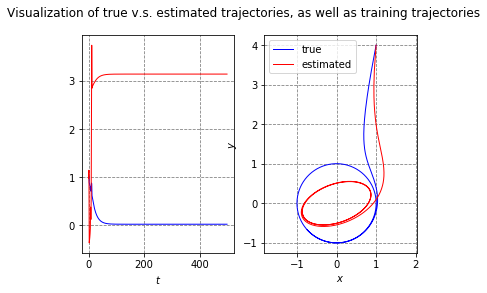

In [0]:
# -*- coding: utf-8 -*-
#
#    ad303.py written by A. Date 2020.3.5 
#    (It seems that this code still have bugs.)
#
import numpy as np
import torch
import matplotlib.pyplot as plt

T = 10 
dt = 0.01
N = int(T/dt)   # (N+1)点に分割
epochs = 500
# epochs = 2000

# Find the truth.

X0 = torch.tensor( [1.0, 4.0], requires_grad=False) # initial state
B = torch.tensor([[1.0, 1.0],[-1.0,1.0]])
x_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x_log[k] = X.data
  X = X + dt*( torch.matmul(B,X) - X.dot(X)*X )

for i in range(N+1):
  if i % 100 == 0: 
    print(i, x_log[i])

# Experiment 3: Estimate the parameter value of 'a, b' given X0, X7, and X10.
a = torch.tensor(0.98, requires_grad=True) 
b = torch.tensor(0.98, requires_grad=True) 
X0 = torch.tensor( [1.0, 4.0])
A0 = torch.tensor([[0.0, 1.0],[-1.0,1.0]])

mu = 0.1
d = []

a_log = np.zeros(epochs,dtype=float)
b_log = np.zeros(epochs,dtype=float)

for i in range(epochs):
  X = torch.clone(X0)
  A = torch.clone(A0)
  A[0][0] = torch.clone(a)
  A[0][1] = torch.clone(b)

  if i % 10 == 0:
    print(i,':',a.data, b.data)

  target1 = torch.tensor( [0.8305881, 0.56135917],  requires_grad=False)
  target2 = torch.tensor( [-0.74309045 -0.67291659],  requires_grad=False)

  for k in range(N+1):
    X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )
    if k == 700:
      diff = torch.pow(X-target1,2).sum()

  diff = diff + torch.pow(X-target2,2).sum()
  d.append(diff.data)
  diff.backward(retain_graph=True)

  with torch.no_grad(): 
    a_log[i] = a.data
    a.data.sub_(mu*a.grad.data)
    a.grad.data.zero_()
    b_log[i] = b.data
    b.data.sub_(mu*b.grad.data)
    b.grad.data.zero_()

# record estimaed trajectory
x2_log = np.zeros((N+1,2), dtype=float)
X = torch.clone(X0)
for k in range(N+1):
  x2_log[k] = X.data
  X = X + dt*( torch.matmul(A,X) - X.dot(X)*X )

print(d)

fig = plt.figure()
fig.suptitle('Visualization of true v.s. estimated trajectories, as well as training trajectories') 
ax = fig.add_subplot(1,2,1)
ax.grid(True, color='gray', linestyle='dashed')
ax.plot(a_log, linewidth=1.0, color="b",linestyle="solid",label="a")
ax.plot(b_log, linewidth=1.0, color="r",linestyle="solid",label="b")
ax.set_xlabel("$t$")

ax = fig.add_subplot(1,2,2)
ax.grid(True, color='gray', linestyle='dashed')
ax.plot(x_log[:,0], x_log[:,1], linewidth=1.0, color="b",linestyle="solid",label="true")
ax.plot(x2_log[:,0], x2_log[:,1], linewidth=1.0, color="r",linestyle="solid",label="estimated")
ax.set_aspect('equal','datalim')
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend()
plt.show()
fig.savefig('ad303.pdf') 